In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader,random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import glob

In [ ]:
train_data_full=[]
test_data_full=[]

files = glob.glob("/content/drive/MyDrive/AI_FYP/*1h.csv")

train_data_full , train_ma_full= [],[]
test_data_full , test_ma_full= [],[]
for f in files:
  data_df = pd.read_csv(f)

  data_df = data_df[["close"]]

  data = data_df.pct_change().dropna()

  l = data.shape[0]
  idx = int(l*0.8)
  train_data= data[:idx]
  test_data = data[idx:]

  train_data_sli = np.lib.stride_tricks.sliding_window_view(train_data,(168+1,train_data.shape[1])).squeeze().astype(np.float32)

  test_data_sli = np.lib.stride_tricks.sliding_window_view(test_data,(168+1,test_data.shape[1])).squeeze().astype(np.float32)

  train_data_full.append(train_data_sli)

  test_data_full.append(test_data_sli)

In [ ]:
train_data_full=np.concatenate(train_data_full,axis=0)
test_data_full=np.concatenate(test_data_full,axis=0)

In [ ]:
train_x,train_y = train_data_full[:,:-1],train_data_full[:,-1]
test_x,test_y = test_data_full[:,:-1],test_data_full[:,-1]

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pickle

In [ ]:
threshold = 0

def t_train(threshold,x,y,test_x,test_y):
  label = []
  for num in y:
    if num>threshold:
      label.append(1)
    elif num<-threshold:
      label.append(-1)
    else:
      label.append(0)
  label = np.array(label)
  
  clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
  clf.fit(x, label)

  test_label = []
  for num in test_y:
    if num>threshold:
      test_label.append(1)
    elif num<-threshold:
      test_label.append(-1)
    else:
      test_label.append(0)
  test_label = np.array(test_label)

  out = clf.predict(test_x)
  acc = np.mean(out==test_label)
  return clf,out,acc

In [ ]:
clf,out,acc = t_train(0,train_x,train_y,test_x,test_y)

In [ ]:
filename = '/content/drive/MyDrive/AI_FYP/svm_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
all_signal = []
signal_return = []
b_h_return = []
all_acc = []
final_return=[]
for f in files:
  data_df = pd.read_csv(f)

  data_df = data_df[["close"]]

  data = data_df.pct_change().dropna()

  l = data.shape[0]
  idx = int(l*0.8)
  train_data= data[:idx]
  test_data = data[idx:]

  final_gain = ((data_df.iloc[-1]-data_df.iloc[idx])/data_df.iloc[idx]).values[0]

  test_data_sli = np.lib.stride_tricks.sliding_window_view(test_data,(168+1,test_data.shape[1])).squeeze().astype(np.float32)
  test_x,test_y = test_data_sli[:,:-1],test_data_sli[:,-1]

  test_label = []
  for num in test_y:
    if num>threshold:
      test_label.append(1)
    else:
      test_label.append(-1)
    # elif num<-threshold:
    #   test_label.append(-1)
    # else:
    #   test_label.append(0)
  test_label = np.array(test_label)

  signal = clf.predict(test_x)

  count = 0
  for i in range(len(test_label)):
    if test_label[i]==out[i]:
      count+=1
  acc = count/len(test_label)

  ret = test_y

  exp_return = signal*ret

  all_signal.append(signal)
  signal_return.append(exp_return)
  b_h_return.append(ret)
  all_acc.append(acc)
  final_return.append(final_gain)

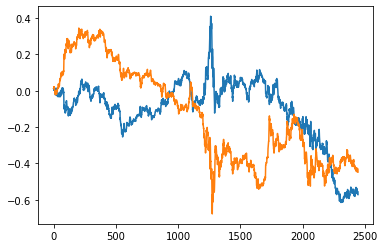

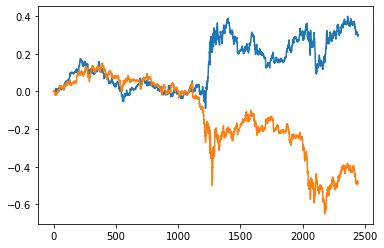

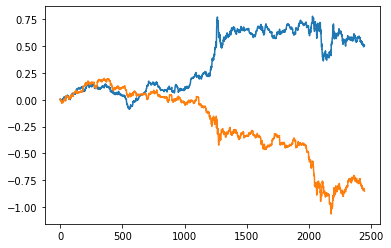

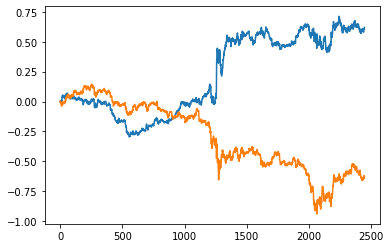

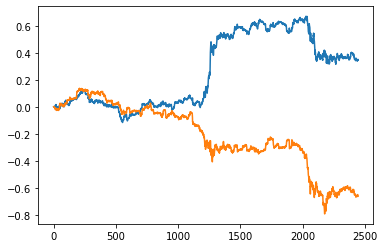

In [ ]:
for i in range(len(signal_return)):
  count = np.arange(len(signal_return[i]))
  plt.plot(count,np.cumsum(signal_return[i]))
  plt.plot(count,np.cumsum(b_h_return[i]))
  plt.show()
  # print(np.sum(signal_return[i]))
  # print(np.sum(b_h_return[i]))

In [ ]:
sig_ret = np.vstack(signal_return)
b_h_ret = np.vstack(b_h_return)
all_sig = np.vstack(all_signal)

In [ ]:
np.save("/content/drive/MyDrive/AI_FYP/SVM_return_data/1h_signal_return.npy",sig_ret)
np.save("/content/drive/MyDrive/AI_FYP/SVM_return_data/1h_buy_hold_return.npy",b_h_ret)
np.save("/content/drive/MyDrive/AI_FYP/SVM_return_data/1h_signal.npy",all_sig)
np.save("/content/drive/MyDrive/AI_FYP/SVM_return_data/1h_acc.npy",np.array(all_acc))
np.save("/content/drive/MyDrive/AI_FYP/SVM_return_data/1h_final_gain.npy",np.array(final_return))

In [ ]:
sig_ret.shape

In [ ]:
np.load("/content/drive/MyDrive/AI_FYP/SVM_return_data/acc.npy")

In [ ]:
all_acc